In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


![alt text](https://github.com/callysto/callysto-sample-notebooks/blob/master/notebooks/images/Callysto_Notebook-Banner_Top_06.06.18.jpg?raw=true)  


<h1 align='center'>Environment Canada Weather Data Notebook Demo</h1>

<h4 align='center'>Laura Gutierrez Funderburk $\mid$ Data Exploration $\mid$ Canada Historical Climate Data</h4>

<h2 align='center'>Abstract</h2>

In this notebook we explore dataset commands implemented by Siang Lim in his notebook https://github.com/csianglim/weather-gc-ca-python to pull large datasets from http://climate.weather.gc.ca/ to the Jupyter Notebook environment. We extend his work by generalizing individual commands into functions. His repository is currently under the MIT license. 


<h3> Updates </h3>
- October 4th 2018: Environment Canada API updated, we need to skip 15 rows instead of 16. `getHourlyData()` updated with skiprows=15

<h2 align='center'>Extracting & Cleaning Data</h2>

In this section we select a data set, download and clean it. We will download data by location and frequency, were locations can either be provinces within Canada or cities within provinces. Frequency refers to the rate at which data was updated in the climate.weather.gc.ca database.  We define basic commands and definitions, and apply functions to extract metadata for climate data for BC. We use definitions to refine our search and obtain data for Abbotsford. We then use the associated stationID to obtain full data set for a specific time range, which we then arrange into a pandas dataframe and plot using Python package matplotlib. 

In [2]:
#!pip install tqdm --user

In [3]:
# Import libraries and modules
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import rrule
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import requests
import re
from fuzzywuzzy import fuzz 
from tqdm import tnrange, tqdm_notebook
from time import sleep

<h3 align='center'>Downloading Data by Location and Frequency</h3>

In this first part of the notebook, we will download raw dara from http://climate.weather.gc.ca/historical_data. We will use the BeautifulSoup module, along with pandas dataframes to extract and parse the data. 

We will first define a set of functions whose purpose is to extract metadata from this website and parse, and will then apply the functions on small datasets. 

The metadata will provide information on Station Number associated with the data for specific locations, start date and frequency with which the data was collected. 

<h4 align='center'>Function Definition Area</h4>

We define the following functions, please use in the suggested order

1. store_data_in_soup_frames()

2. generate_pandas_dataframe_from_soups()

3. get_weather_data_by_loc()

4. get_weather_data_by_date()

In [4]:

def store_data_in_soup_frames(province,start_year,max_pages):
    
    try:
        if province in {'BC','PE','NS','NL','NB','QC','ON','MB','SK','AB','YT','NT'} and type(start_year)==str and len(start_year)==4 and type(max_pages)==int:
        # Store each page in a list and parse them later
            soup_frames = []

            for i in tnrange(100, desc='Downloading Data'):
                startRow = 1 + i*100
                sleep(0.01)
    
                base_url = "http://climate.weather.gc.ca/historical_data/search_historic_data_stations_e.html?"
                queryProvince = "searchType=stnProv&timeframe=1&lstProvince={}&optLimit=yearRange&".format(province)
                queryYear = "StartYear={}&EndYear=2017&Year=2017&Month=5&Day=29&selRowPerPage=100&txtCentralLatMin=0&txtCentralLatSec=0&txtCentralLongMin=0&txtCentralLongSec=0&".format(start_year)
                queryStartRow = "startRow={}".format(startRow)

                response = requests.get(base_url + queryProvince + queryYear + queryStartRow) # Using requests to read the HTML source
                soup = BeautifulSoup(response.text, 'html.parser') # Parse with Beautiful Soup
                soup_frames.append(soup)

            return soup_frames
        else:
            print("INVALID INPUT\n\nENTER A PROVINCE AS A STRING:\n'BC','PE','NS','NL','NB','QC','ON','MB','SK','AB','YT','NT'\nENTER YEAR AS A STRING:'1992'\nENTER A MAXIMUM NUMBER OF PAGES AS AN INTEGER, i.e. 1,2,3,4,5")
    except:
        print("INVALID INPUT\n\nENTER A PROVINCE AS A STRING:\n'BC','PE','NS','NL','NB','QC','ON','MB','SK','AB','YT','NT'\nENTER YEAR AS A STRING:'1992'\nENTER A MAXIMUM NUMBER OF PAGES AS AN INTEGER, i.e. 1,2,3,4,5")

In [5]:
def generate_pandas_dataframe_from_soups(soup_frames):
    
    # Empty list to store the station data
    station_data = []
    for i in tnrange(len(soup_frames), desc='Generating Pandas DataFrames'):# For each soup
        sleep(0.01)
        forms = soup_frames[i].findAll("form", {"id" : re.compile('stnRequest*')}) # We find the forms with the stnRequest* ID using regex
        for form in forms:
            try:

                # The stationID is a child of the form
                station = form.find("input", {"name" : "StationID"})['value']
            
                # The station name is a sibling of the input element named lstProvince
                name = form.find("input", {"name" : "lstProvince"}).find_next_siblings("div")[0].text
            
                # The intervals are listed as children in a 'select' tag named timeframe
                timeframes = form.find("select", {"name" : "timeframe"}).findChildren()
                intervals =[t.text for t in timeframes]
            
                # We can find the min and max year of this station using the first and last child
                years = form.find("select", {"name" : "Year"}).findChildren()            
                min_year = years[0].text
                max_year = years[-1].text
            
                # Store the data in an array
                data = [station, name, intervals, min_year, max_year]
                station_data.append(data)
            except:
                pass

    # Create a pandas dataframe using the collected data and give it the appropriate column names
    stations_df = pd.DataFrame(station_data, columns=['StationID', 'Name', 'Intervals', 'Year Start', 'Year End'])
    return stations_df

In [6]:
def get_weather_data_by_loc(stations_df, location_name):
    
    try:
        tolerance = 90
        by_city_df = stations_df[stations_df['Name'].apply(lambda x: fuzz.token_set_ratio(x, location_name)) > tolerance]
        return by_city_df
    except:
        print("INVALID INPUT. ENTER A PANDAS DF FROM SOUPS AND A LOCATION, i.e, VANCOUVER, WHISTLER...")
    


In [7]:
def switch_rate(option):
    switcher={
        1: "Hourly",
        2: "Daily",
        3: "Weekly",
        4: "Monthly"
    }
    
    return switcher.get(option,"Invalid option was chosen, please enter an integer value from the list 1,2,3,4")

In [8]:
def get_weather_data_by_date(stations_df, chosen_option):
    
    try:
        
        weather_rate = switch_rate(chosen_option)
        chosen_weather_rate = stations_df.loc[stations_df['Intervals'].map(lambda x: weather_rate in x)]
        return chosen_weather_rate
    except:
        print("INVALID INPUT. ENTER A PANDAS DF FROM SOUPS AND AN INTEGER FROM THE LIST 1, 2, 3, 4")

<h4 align='center'>Apply Functions to get Data by Province and Frequency</h4>

Let us take the province BC, start year 2016 and download stations metadata.

In [9]:
# 0. Specify Parameters
province = "BC"      # Which province to parse?
start_year = "2016"  # I want the results to go back to at least 2006 or earlier
max_pages = 2        # Number of maximum pages to parse, EC's limit is 100 rows per page, there are about 500 stations in BC with data going back to 2006


We download pages using soups


In [10]:
# 1. Use store_data_in_soup_frames() function to download data
soup_frames = store_data_in_soup_frames("BC",'1999',max_pages)

HBox(children=(IntProgress(value=0, description='Downloading Data', style=ProgressStyle(description_width='initial')), HTML(value='')))

We organize the soup frames into pandas data frames

In [11]:
# 2. Organize data into a pandas dataframe
stations_df = generate_pandas_dataframe_from_soups(soup_frames)

HBox(children=(IntProgress(value=0, description='Generating Pandas DataFrames', style=ProgressStyle(description_width='initial')), HTML(value='')))

We preview the first five entries. In the table below you can see five columns: the StationsID will be the key part to accessing full data sets. The Name contains city names found under BC, the Intervals column states the frequency with which the data was updated, while Year Start and Year end state the years between which the data was collected. 


In [12]:
# Preview first few rows
stations_df.head()

,StationID,Name,Intervals,Year Start,Year End
0,1308,100 MILE HOUSE,"[Daily, Monthly]",1970,1999
1,1309,100 MILE HOUSE 6NE,"[Daily, Monthly]",1987,2018
2,559,108 MILE HOUSE ABEL LAKE,"[Daily, Monthly]",1987,2018
3,50308,ABBOTSFORD A,"[Hourly, Daily]",2011,2018
4,702,ABBOTSFORD A,"[Hourly, Daily, Monthly]",1953,2012


Let's get all entries in the stations_df that have Daily intervals. Note that this function picks those that contain the word "Daily" but will not exlude other frequencies.

In [13]:
daily_stations = get_weather_data_by_date(stations_df,1)

daily_stations.head()

,StationID,Name,Intervals,Year Start,Year End
3,50308,ABBOTSFORD A,"[Hourly, Daily]",2011,2018
4,702,ABBOTSFORD A,"[Hourly, Daily, Monthly]",1953,2012
5,54238,ABBOTSFORD A,"[Hourly, Daily]",2016,2018
6,374,ADDENBROKE ISLAND,"[Hourly, Daily, Monthly]",1994,2001
8,706,AGASSIZ RCS,"[Hourly, Daily, Monthly]",1994,2018


Let's now pick only those entries that belong to Abbotsford. 

In [14]:
# 3. Select subset of the data from a specific location|
location_name = "Abbotsford"
city_data = get_weather_data_by_loc(stations_df,location_name)

In [15]:
# preview first few entries
city_data

,StationID,Name,Intervals,Year Start,Year End
3,50308,ABBOTSFORD A,"[Hourly, Daily]",2011,2018
4,702,ABBOTSFORD A,"[Hourly, Daily, Monthly]",1953,2012
5,54238,ABBOTSFORD A,"[Hourly, Daily]",2016,2018


We can refine our search and select only those that contain Monthly intervals.

In [16]:
chosen_option = 4
get_weather_data_by_date(city_data,chosen_option)

,StationID,Name,Intervals,Year Start,Year End
4,702,ABBOTSFORD A,"[Hourly, Daily, Monthly]",1953,2012


<h3 align='center'>Summary</h3>

In the section above, we pulled metadata from http://climate.weather.gc.ca/historical_data by province, city and intervals. In the next section we will explore usage of the StationID entry to pull full datasets. 

<h3 align='center'>Downloading Data by Station</h3>

Now that we have access to a wide range of datasets to choose from, we will build functions that help us get full data sets via the use of the StationID. 

In [17]:
# Call Environment Canada API
# Returns a dataframe of data
# UPDATE: October 4th 2018: Environment Canada API updated, 
#    we need to skip 15 rows instead of 16. `getHourlyData()` updated with skiprows=15
def getHourlyData(stationID, year, month):
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=1".format(stationID, year, month)
    api_endpoint = base_url + query_url
    return pd.read_csv(api_endpoint, skiprows=15)

In [18]:
def download_data_date_range(stationID,start_d,end_d):
    try:
        #stationID = 51442
        start_date = datetime.strptime(start_d, '%b%Y')
        end_date = datetime.strptime(end_d, '%b%Y')

        frames = []
        ran = [dt for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date)]
        ran_len = len(ran)
        for i in tnrange(ran_len, desc='Downloading Data'):    
            sleep(0.01)
            df = getHourlyData(stationID, ran[i].year, ran[i].month)
            frames.append(df)

        weather_data = pd.concat(frames)
        weather_data['Date/Time'] = pd.to_datetime(weather_data['Date/Time'])
        weather_data['Temp (°C)'] = pd.to_numeric(weather_data['Temp (°C)'])
        return weather_data
    
    except:
        print("INVALID INPUT. ENTER AN INTEGER FOR stationID, A STRING FOLLOWING THE FORMAT MonYEAR, i.e. Jun2015")
    

Let us try the stationID from the Abbotsford metadata. Recall that from our example we have:

In [19]:
location_name = "Abbotsford"
city_data = get_weather_data_by_loc(stations_df,location_name)
chosen_option = 4
get_weather_data_by_date(city_data,chosen_option)

,StationID,Name,Intervals,Year Start,Year End
4,702,ABBOTSFORD A,"[Hourly, Daily, Monthly]",1953,2012


We observe that this dataset has stationID 702, with start date 1953 and end date 2012. Since this dataset has hourly updates, let us pick a small subset. We will select Jun2003 as start date and Jun2004 as end date. 

In [20]:
weather_data = download_data_date_range(702,'Jun2003','Jun2004')


HBox(children=(IntProgress(value=0, description='Downloading Data', max=13, style=ProgressStyle(description_width='initial')), HTML(value='')))

In [21]:
weather_data.head()

,Date/Time,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,2003-06-01 00:00:00,2003,6,1,00:00,12.2,NaN,8.5,NaN,78.0,...,NaN,24.1,NaN,101.44,NaN,NaN,NaN,NaN,NaN,Mostly Cloudy
1,2003-06-01 01:00:00,2003,6,1,01:00,12.2,NaN,8.4,NaN,78.0,...,NaN,24.1,NaN,101.45,NaN,NaN,NaN,NaN,NaN,Mostly Cloudy
2,2003-06-01 02:00:00,2003,6,1,02:00,12.1,NaN,8.6,NaN,79.0,...,NaN,24.1,NaN,101.47,NaN,NaN,NaN,NaN,NaN,Mostly Cloudy
3,2003-06-01 03:00:00,2003,6,1,03:00,12.4,NaN,8.6,NaN,78.0,...,NaN,24.1,NaN,101.48,NaN,NaN,NaN,NaN,NaN,Mostly Cloudy
4,2003-06-01 04:00:00,2003,6,1,04:00,11.3,NaN,8.6,NaN,83.0,...,NaN,32.2,NaN,101.49,NaN,NaN,NaN,NaN,NaN,Mostly Cloudy


We can use matplotlib to plot this data. 

<h3 align='center'> Plot average data and a rolling average </h3>

Notice the broken lines, they indicate missing data points.  These entries are coded as NaN in our pandas dataframes. 

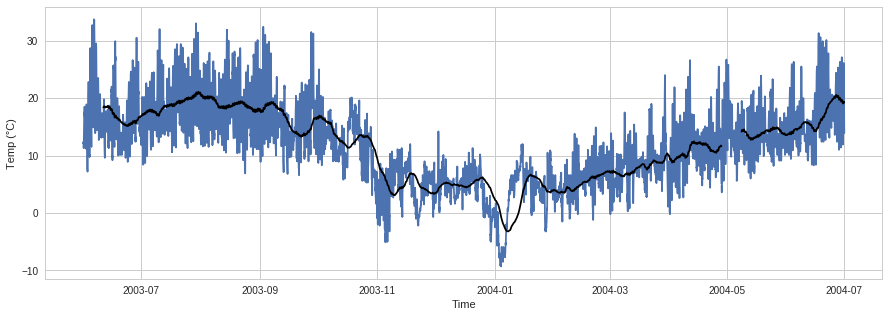

In [22]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
plt.plot(weather_data['Date/Time'], weather_data['Temp (°C)'])
plt.plot(weather_data['Date/Time'], weather_data['Temp (°C)'].rolling(window=250,center=False).mean(), '-k', alpha=1.0)
plt.ylabel('Temp (°C)')
plt.xlabel('Time')
plt.show()

<h3 align='center'> Fix missing data points by interpolation</h3>

Siang implemented the interpolate method to correct missing datapoints. He notes that data accuracy is lost in the process. 

In [23]:
# Don't really care about accuracy right now, use simple linear interpolation
weather_data['Temp (°C)'] = weather_data['Temp (°C)'].interpolate()

Then plot the data again:

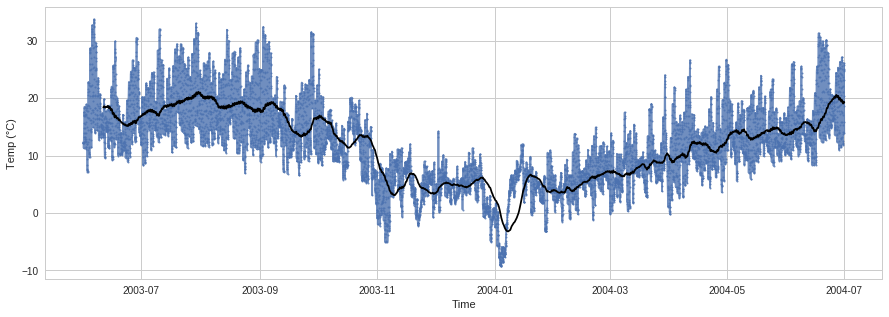

In [24]:
%matplotlib inline
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
plt.plot(weather_data['Date/Time'], weather_data['Temp (°C)'], '-o', alpha=0.8, markersize=2)
plt.plot(weather_data['Date/Time'], weather_data['Temp (°C)'].rolling(window=250,center=False).mean(), '-k', alpha=1.0)
plt.ylabel('Temp (°C)')
plt.xlabel('Time')
plt.show()

<h2 align='center'> Exporting Data </h2>

We can use the to_csv pandas method to save our dataset into a CSV file for later analysis or exploration with other software. 

In [25]:
stations_df.to_csv('stations.csv')

<h2 align='center'>Summary</h2>

In this notebook we explored functions and commands written and improved by Siang Liam and Laura Gutierrez Funderburk whose goal is to extract complete data sets from http://climate.weather.gc.ca/historical_data in an efficient manner for data analysis. We first pulled metadata and formatted using the Soups package, and then arranged it in a tabular form using pandas dataframes. Using the dataframes, we found that we could easily plot it using matplotlib. Furthermore, we interpolate the data to take care of missing data points. 

![alt text](https://github.com/callysto/callysto-sample-notebooks/blob/master/notebooks/images/Callysto_Notebook-Banners_Bottom_06.06.18.jpg?raw=true)